Inspired by [Brian McFee](https://gist.github.com/bmcfee/69a3f4c82c1508aaab76) and [Jesse Engel](https://gist.github.com/jesseengel/e223622e255bd5b8c9130407397a0494).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, chirp
import librosa
from utils.specshow import specshow
from utils.imutil import imshow
from utils.pixelated import *

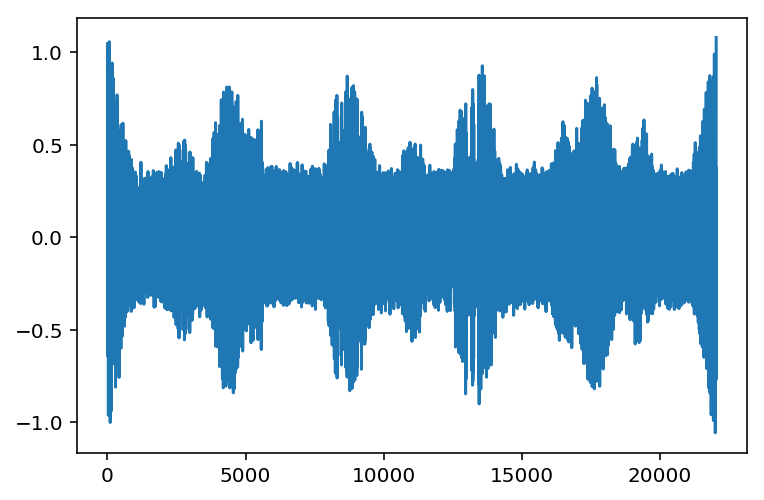

In [2]:
# sample signal ported from matlab, borrow from:
# https://people.ece.cornell.edu/land/PROJECTS/ReassignFFT/index.html

Fs = 22050 
tmax = 1.0 
t = np.linspace(0, tmax, Fs)
t.shape, t.max()

# first FM signal
FM1_center_freq = 2000 
FM1_depth = 0.1 
FM1_mod_freq = 25 
FM1_amp = 0.5 
AM1_freq = 5 
FM1_mod = FM1_depth * np.cumsum(np.cos(2*np.pi*FM1_mod_freq*t)) 
y = FM1_amp * np.cos(2*np.pi*FM1_center_freq*t + FM1_mod) * \
    np.cos(2*np.pi*AM1_freq*t)**2 * (np.cos(2*np.pi*AM1_freq*t)>0) 
    
# second FM signal
FM2_center_freq = 1500 
FM2_depth = 0.05 
FM2_mod_freq = 20 
FM2_amp = 0.25 
AM2_freq = 8 
FM2_mod = FM2_depth * np.cumsum(np.cos(2*np.pi*FM2_mod_freq*t)) 
y = y + FM2_amp * np.cos(2*np.pi*FM2_center_freq*t + FM2_mod) * \
    np.cos(2*np.pi*AM2_freq*t)**2 * (np.cos(2*np.pi*AM2_freq*t)>0) 

# additive, low passed, gaussian noise
noise = np.random.randn(Fs)
b, a = butter(4, 0.2)
noise = lfilter(b, a, noise)
y = y + 0.1*noise 

#  linear chirp
y = y + .3*chirp(t, 1000, tmax, 3000) 

plt.plot(y)

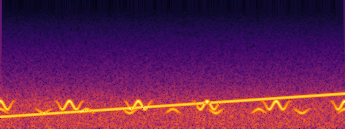

0:2.00 @ 44100Hz, 345 frames x 129 bins @ 256 spacing


In [3]:
stft = librosa.stft(y, n_fft=256)
specshow(stft.T, zoom=3)

In [4]:
pitches, magnitudes = librosa.piptrack(y, sr=Fs, n_fft=256, fmin=10, fmax=Fs/2, hop_length=16)

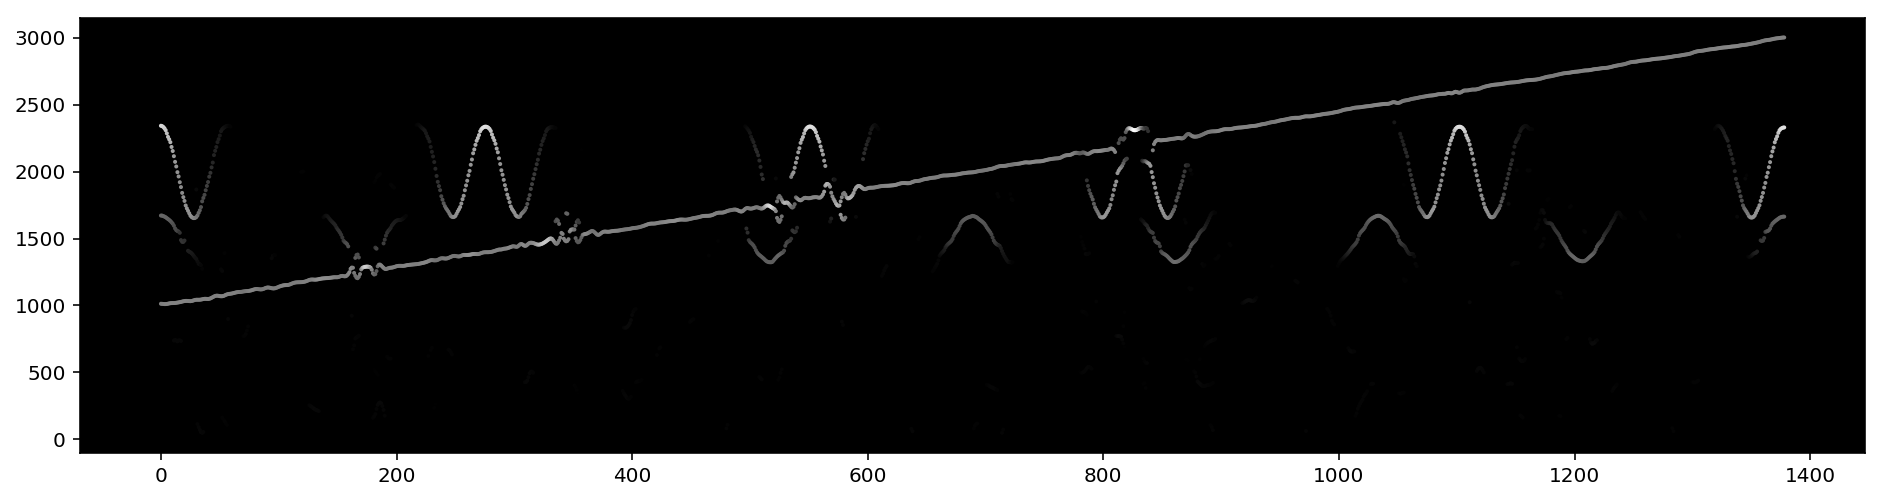

In [5]:
points = []
colors = []
for freq, row in enumerate(magnitudes):
    for time, magnitude in enumerate(row):
        if magnitude > 0:
            points.append((time, pitches[freq,time]))
            colors.append(magnitude)
points = np.asarray(points)

plt.figure(figsize=(16,4))
ax = plt.gca()
ax.set_facecolor('black')
plt.scatter(points[:,0], points[:,1], edgecolors=None, s=1, c=colors, cmap='gray')
plt.show()

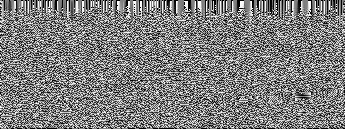

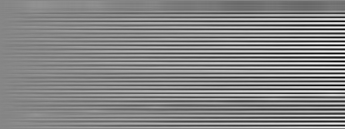

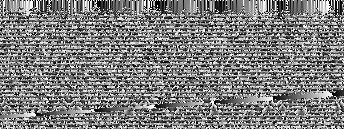

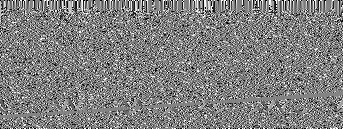

In [6]:
def normalize(x):
    x_mod = np.copy(x)
    x_mod -= x_mod.min()
    x_mod /= x_mod.max()
    return x_mod

mag, phase = librosa.core.magphase(stft)
phase_angle = np.angle(phase)
phase_unwrapped = np.unwrap(phase_angle) 
phase_derivative1 = np.diff(phase_unwrapped, axis=1)
phase_derivative2 = np.diff(np.unwrap(phase_derivative1), axis=1)

imshow(255 * np.flipud(normalize(phase_angle)), zoom=4)
imshow(255 * np.flipud(normalize(phase_unwrapped)), zoom=4)
imshow(255 * np.flipud(normalize(phase_derivative1)), zoom=4)
imshow(255 * np.flipud(normalize(phase_derivative2)), zoom=4)

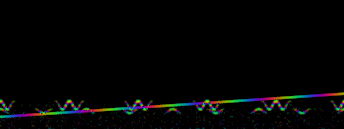

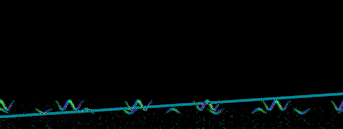

In [7]:
from utils.rainbow import to_rainbow
from librosa import amplitude_to_db

db = normalize(amplitude_to_db(mag, top_db=30))
db = np.expand_dims(db, axis=-1)
imshow(np.flipud(db[:,:-1] * to_rainbow(phase_derivative1)), zoom=4)
imshow(np.flipud(db[:,:-2] * to_rainbow(phase_derivative2)), zoom=4)